In [85]:
# recreate the job posts csv with correct classification

In [86]:
import pandas as pd

In [87]:
# read in job posts
# we agreed on 1 from each of the following categories for now: HR SALES INFORMATION-TECHNOLOGY
df_jobposts = pd.read_csv('data/processed/jobposts.csv')

categories = ['INFORMATION-TECHNOLOGY', 'SALES', 'HR']

df_filtered = df_jobposts[df_jobposts['predictions'].isin(categories)]

# Sample 1 job postings per category
df_sampled = df_filtered.groupby('predictions', group_keys=False).sample(n=1, random_state=42)
df_sampled = df_sampled[['predictions', 'job_description']]

# Split into separate DataFrames
df_it = df_sampled[df_sampled['predictions'] == 'INFORMATION-TECHNOLOGY']
df_sales = df_sampled[df_sampled['predictions'] == 'SALES']
df_hr = df_sampled[df_sampled['predictions'] == 'HR']

In [88]:
print(df_it.iloc[0]["predictions"])
print(df_it.iloc[0]["job_description"])

INFORMATION-TECHNOLOGY
C# Developer Job in Chicago 60601, Illinois US CyberCoders Search. Apply. Done. Learn more about CyberCoders C# Developer Apply Chicago, IL Full-Time $80,000 - $140,000 Job Details If you are a C# Developer with experience , please read on!Job Title: C# DeveloperLocation: Chicago, ILSalary: $80-140kThe Company: We are a quickly growing mid- stage start up that is born and bred in Chicago. Our platform has created a high impact on a fast-paced industry and we are looking to add a great C#Developer that can keep up!!What You Will Be Doing- Develop high quality Desktop and tablet applications- Propose and Deliver scalable enhancements to our GUI's-Stay up to date on latest features in .NET and WPF - incorporate into our platform-Build agile software methodologies- Participate in design sessions and code reviews- Collaborate with cross-functional teamsWhat You Need for this PositionRequirements:- Bachelor’s degree in Computer Science, Engineering, Math or equivalent-

In [89]:
df_cvs = pd.read_csv('data/resume.csv')

# Take 50% relevant and 50% irrelevant CVs (30 CVs total)
# Filter CVs by category
relevant_cvs_it = df_cvs[df_cvs['Category'] == 'INFORMATION-TECHNOLOGY'].sample(n=50, random_state=42)
irrelevant_cvs_it = df_cvs[df_cvs['Category'] != 'INFORMATION-TECHNOLOGY'].sample(n=50, random_state=42)

relevant_cvs_sales = df_cvs[df_cvs['Category'] == 'SALES'].sample(n=50, random_state=42)
irrelevant_cvs_sales = df_cvs[df_cvs['Category'] != 'SALES'].sample(n=50, random_state=42)

relevant_cvs_hr = df_cvs[df_cvs['Category'] == 'HR'].sample(n=50, random_state=42)
irrelevant_cvs_hr = df_cvs[df_cvs['Category'] != 'HR'].sample(n=50, random_state=42)

# Combine into one 100-row dataset
df_cvs_it_test = pd.concat([relevant_cvs_it, irrelevant_cvs_it], ignore_index=True)
df_cvs_sales_test = pd.concat([relevant_cvs_sales, irrelevant_cvs_sales], ignore_index=True)
df_cvs_hr_test = pd.concat([relevant_cvs_hr, irrelevant_cvs_hr], ignore_index=True)

# Shuffle the result (so the LLM doesn't learn order)
df_cvs_it_test = df_cvs_it_test.sample(frac=1, random_state=42).reset_index(drop=True)
df_cvs_sales_test = df_cvs_sales_test.sample(frac=1, random_state=42).reset_index(drop=True)
df_cvs_hr_test = df_cvs_hr_test.sample(frac=1, random_state=42).reset_index(drop=True)

In [90]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from ibm_watsonx_ai import APIClient
from ibm_watsonx_ai import Credentials
from ibm_watsonx_ai.foundation_models import ModelInference
from ibm_watsonx_ai.foundation_models.schema import TextGenParameters
from sklearn.metrics import classification_report 
from tqdm import tqdm
from decouple import config

In [91]:
WX_API_KEY = config('WX_API_KEY')

credentials = Credentials(
    url = "https://us-south.ml.cloud.ibm.com",
    api_key = WX_API_KEY
)

client = APIClient(
    credentials=credentials, 
    project_id="c8d96942-6948-4a06-9909-2ea6394aca25"
)

In [92]:
# Define generation parameters
PARAMS = TextGenParameters(
    temperature=0,
)

model = ModelInference(
    api_client=client,
    model_id="meta-llama/llama-3-3-70b-instruct",
    params=PARAMS,
    
)

In [93]:
def get_job_requirements(model, job_description):
    system_prompt = """You an HR assistant, your primary responsibility will be to review CV applications. To excel in this role, you will need to consider the following key aspects:

    * Reviewing CVs to identify top candidates for various job openings
    * Ensuring compliance with company policies and regulations
    * Collaborating with hiring managers to understand job requirements and preferences

    You will need to consider the following factors:
    ### Criteria for Evaluating CVs
    * **Educational Qualifications**: 
        + Degree and field of study
        + Institution and location
        + Date of completion
        + Any relevant certifications
    * **Work Experience**: 
        + Job titles and roles
        + Company names and locations
        + Dates of employment
        + Brief descriptions of job responsibilities
    * **Certifications**: relevant certifications and licenses
    * **Achievements**: notable achievements and awards
    * **Relevant Projects**: relevant projects and contributions
    * **Skills**: 
        + **Necessary Skills**: skills required to perform the job
        + **Trainable Skills**: skills that can be learned or developed
        + **Additional Skills**: skills that might be helpful but not essential
    * **Personal Attributes and Values**: 
        + Soft skills such as communication, teamwork, and problem-solving
        + Personal values such as adaptability, reliability, and integrity
    * **Red Flags**: 
        + Job hopping
        + Stagnant jobs and roles
        + Excessive mistakes in the resume
    * **Job Requirements**: how well the candidate's skills and experience match the job requirements
    * **Company Culture**: how well the candidate's values and personality align with the company culture

    If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
    """

    task_prompt = """Using the following job ad, extract only the most relevant criteria that will be used to evaluate candidates on.
    When writing evaluation criteria for the specific job position, consider if it makes sense setting targets as well, to make it easier when evaluating. For example do we require a certain level of education or certain amount of experience for the position?

    Job post:
    {job_post}

    Based on the job post, provide a list of the most relevant criteria to evaluate candidates on.
    """

    return (model.chat([
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": task_prompt.format(job_post=job_description)}
    ]))["choices"][0]["message"]["content"]


In [94]:
def get_candidate_evaluation(model, job_requirements, resume):
    system_prompt = f"""You an HR assistant. Your primary responsibility will be to review CV applications. When answering, do not use new lines. Instead, write everything in a single line of text.
    Currently our company is rapidly expanding. You will be provided with the requirements for a job position we have, as well as the resume of a candidate.
    The goal is to evaluate the candidate based on the given criteria.
    Based on how well the candidate performs according each criterion, provide a score from 0 to 10, where 0 = very poor fit and 10 = excellent fit..
    After the evaluation of each criterion is done, you will give a final grade for the candidate to give an overall impression. Write 'Final Grade:' before concluding with the final grade.
    Provide the final grade in the following json format: 
    {{
        "score": int,
        "explanation": "string"
    }}
    where score is a number from 0 to 10, and explanation is a short justification of the score (max 2 sentences).

    Important: If the candidate has a strong background in a related technical field or shows clear evidence of quickly acquiring new skills, consider this as a **positive signal**. Do not penalize candidates too harshly for lacking specific tools or systems if they could reasonably be expected to learn them quickly, especially within the same domain (e.g., IT, software, analytics).

    Use professional judgment to assess both current fit and realistic potential.
    """

    task_prompt = """Hey. We had a new candidate apply for one of our jobs. Here are the requirements for the position:

    Job requirements:
    {job_requirements}

    And here is the resume of a candidate. 
    {resume}"
    
    Please evalute the resume provided based on the criteria. After the evaluation is done, provide a final score for the candidate from 0 to 10.
    """

    return (model.chat([
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": task_prompt.format(job_requirements=job_requirements, resume=resume)}
    ]))["choices"][0]["message"]["content"]


In [95]:
import re
import json

def extract_final_grade(text):
    # keyword = "Final Grade:"
    # if keyword in text:
    #     return text.split(keyword, 1)[1].strip()
    # return text
    match = re.search(r'\{.*?\}', text)
    if match:
        try:
            return json.loads(match.group(0))
        except json.JSONDecodeError:
            print(f"Found brackets, but content is not valid JSON. {text}")
            return text

In [96]:
# job_requirements = get_job_requirements(model, df_it.iloc[0]["job_description"])

In [97]:
# evaluation = get_candidate_evaluation(model, job_requirements, relevant_cvs_it.iloc[0]["Resume_str"])

In [98]:
# evaluation

In [99]:
# extract_final_grade(evaluation)["score"]

In [ ]:
scores = []
explanations = []

for i, post in df_it.iterrows():
    job_requirements = get_job_requirements(model, post["job_description"])

    for j, cv in df_cvs_it_test.iterrows():
        print(j)
        try:
            evaluation = get_candidate_evaluation(model, job_requirements, cv["Resume_str"])
            final_score = extract_final_grade(evaluation)
            scores.append(final_score["score"])
            explanations.append(final_score["explanation"])
        except Exception as e:
            scores.append(0)
            explanations.append("NO_JSON")
            print(e)
    
# Save the dataframe CSV file
df_cvs_it_test['score'] = scores
df_cvs_it_test['explanation'] = explanations
df_cvs_it_test.to_csv('data/processed/base_results/cvs_it_test_scores_advanced_LLM.csv', index=False)

In [ ]:
scores = []
explanations = []

for i, post in df_hr.iterrows():
    job_requirements = get_job_requirements(model, post["job_description"])

    for j, cv in df_cvs_hr_test.iterrows():
        try:
            evaluation = get_candidate_evaluation(model, job_requirements, cv["Resume_str"])
            final_score = extract_final_grade(evaluation)
            scores.append(final_score["score"])
            explanations.append(final_score["explanation"])
        except Exception as e:
            scores.append(0)
            explanations.append("NO_JSON")
            print(e)
    
# Save the dataframe CSV file
df_cvs_hr_test['score'] = scores
df_cvs_hr_test['explanation'] = explanations
df_cvs_hr_test.to_csv('data/processed/base_results/cvs_hr_test_scores_advanced_LLM.csv', index=False)

In [101]:
scores = []
explanations = []

for i, post in df_sales.iterrows():
    job_requirements = get_job_requirements(model, post["job_description"])

    for j, cv in df_cvs_sales_test.iterrows():
        try:
            evaluation = get_candidate_evaluation(model, job_requirements, cv["Resume_str"])
            final_score = extract_final_grade(evaluation)
            scores.append(final_score["score"])
            explanations.append(final_score["explanation"])
        except Exception as e:
            scores.append(0)
            explanations.append("NO_JSON")
            print(e)
    
# Save the dataframe CSV file
df_cvs_sales_test['score'] = scores
df_cvs_sales_test['explanation'] = explanations
df_cvs_sales_test.to_csv('data/processed/base_results/cvs_sales_test_scores_advanced_LLM.csv', index=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [103]:
df_cvs_it_test = pd.read_csv('data/processed/base_results/cvs_it_test_scores_advanced_LLM.csv')
df_cvs_hr_test = pd.read_csv('data/processed/base_results/cvs_hr_test_scores_advanced_LLM.csv')
df_cvs_sales_test = pd.read_csv('data/processed/base_results/cvs_sales_test_scores_advanced_LLM.csv')

df_cvs_it_test_sorted = df_cvs_it_test.sort_values(by='score', ascending=False)
df_cvs_hr_test_sorted = df_cvs_hr_test.sort_values(by='score', ascending=False)
df_cvs_sales_test_sorted = df_cvs_sales_test.sort_values(by='score', ascending=False)


In [104]:
# Define the metrics function to compute mean, median, and top 10 metrics
def compute_metrics(df_sorted, correct_category):
    overall_mean = df_sorted['score'].mean()
    overall_median = df_sorted['score'].median()
    top_10 = df_sorted.head(10)
    top10_mean = top_10['score'].mean()
    top10_median = top_10['score'].median()
    top10_correct_pct = top_10['Category'].value_counts().get(correct_category, 0)
    return [overall_mean, overall_median, top10_mean, top10_median, top10_correct_pct]

In [105]:

# Compute metrics per category
metrics_it = compute_metrics(df_cvs_it_test_sorted, 'INFORMATION-TECHNOLOGY')
metrics_hr = compute_metrics(df_cvs_hr_test_sorted, 'HR')
metrics_sales = compute_metrics(df_cvs_sales_test_sorted, 'SALES')

# Print the metrics per category
print("\nMetrics for IT:")
print(f"Overall Mean IT: {metrics_it[0]:.2f}")
print(f"Overall Median IT: {metrics_it[1]:.2f}")
print(f"Top 10 Mean IT: {metrics_it[2]:.2f}")
print(f"Top 10 Median IT: {metrics_it[3]:.2f}")
print(f"Top 10 Correct Count IT: {metrics_it[4]}/10 ({metrics_it[4] / 10 * 100:.0f}%)")
print("\n--------------------------")
print("\nMetrics for HR:")
print(f"Overall Mean HR: {metrics_hr[0]:.2f}")
print(f"Overall Median HR: {metrics_hr[1]:.2f}")
print(f"Top 10 Mean HR: {metrics_hr[2]:.2f}")
print(f"Top 10 Median HR: {metrics_hr[3]:.2f}")
print(f"Top 10 Correct Count HR: {metrics_hr[4]}/10 ({metrics_hr[4] / 10 * 100:.0f}%)")
print("\n--------------------------")
print("\nMetrics for Sales:")
print(f"Overall Mean Sales: {metrics_sales[0]:.2f}")
print(f"Overall Median Sales: {metrics_sales[1]:.2f}")
print(f"Top 10 Mean Sales: {metrics_sales[2]:.2f}")
print(f"Top 10 Median Sales: {metrics_sales[3]:.2f}")
print(f"Top 10 Correct Count Sales: {metrics_sales[4]}/10 ({metrics_sales[4] / 10 * 100:.0f}%)")



Metrics for IT:
Overall Mean IT: 2.42
Overall Median IT: 2.00
Top 10 Mean IT: 5.90
Top 10 Median IT: 6.00
Top 10 Correct Count IT: 10/10 (100%)

--------------------------

Metrics for HR:
Overall Mean HR: 6.25
Overall Median HR: 7.00
Top 10 Mean HR: 8.80
Top 10 Median HR: 9.00
Top 10 Correct Count HR: 9/10 (90%)

--------------------------

Metrics for Sales:
Overall Mean Sales: 5.26
Overall Median Sales: 6.00
Top 10 Mean Sales: 7.00
Top 10 Median Sales: 7.00
Top 10 Correct Count Sales: 9/10 (90%)


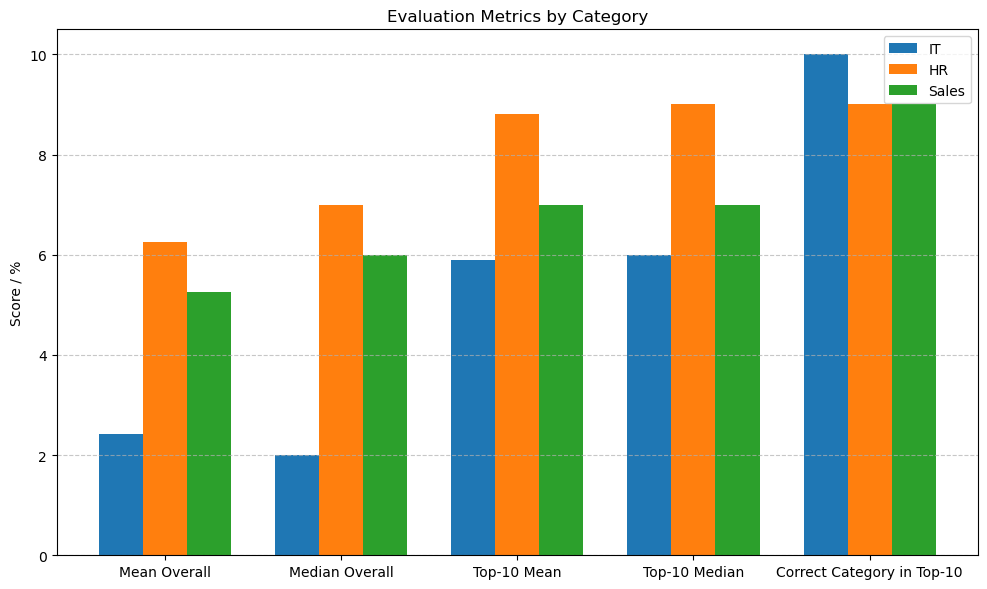

In [106]:
import matplotlib.pyplot as plt

# Show chart
# Labels and setup
metric_labels = ['Mean Overall', 'Median Overall', 'Top-10 Mean', 'Top-10 Median', 'Correct Category in Top-10']
categories = ['IT', 'HR', 'Sales']
x = range(len(metric_labels))

# Create bar chart
width = 0.25
plt.figure(figsize=(10, 6))
plt.bar([p - width for p in x], metrics_it, width=width, label='IT')
plt.bar(x, metrics_hr, width=width, label='HR')
plt.bar([p + width for p in x], metrics_sales, width=width, label='Sales')

# Finalize chart
plt.xticks(x, metric_labels)
plt.ylabel('Score / %')
plt.title('Evaluation Metrics by Category')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()